# Improving on the baseline

Last time, we learned how to take advantage of the [hard work] of the good people at Oxford (now at Google) in order to improve our classifier (err, hotdog detector!). That way, we got a CNN architecture designed by some of the best in the world (I have to say, designed in 2014... we could probably use a better one now). We also saved a ton of money in GPU leasing fees, and got a nice bump to our performance.

However, with the last increase in model complexity, we went over the line. We got some overfitting, so now we have to implement once again a regularization technique. We are going to implement one that actually isn't implemented in VGG16, so if we could go back in time just 4 years, we could have the best image classifier in the world. Its name is [dropout].


[dropout]: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
[hard work]: https://arxiv.org/abs/1409.1556

# Dropout

Dropout is a very counterintuitive technique when you first hear about it, but it really makes a lot of sense after a while. It consists of ignoring the output of some of the units in a layer 

In [1]:
import keras
from keras import backend as K
from keras.applications import VGG16

vgg = VGG16(weights='imagenet', 
            include_top=False, 
            input_shape=(120,120,3))



Using TensorFlow backend.


In [2]:
from keras.layers import Dense, Dropout, Flatten

vgg.trainable = False

detector = keras.Sequential()
detector.add(vgg)
detector.add(Flatten())
detector.add(Dropout(.5))
detector.add(Dense(128, activation='relu'))
detector.add(Dropout(.5))
detector.add(Dense(128, activation='relu'))
detector.add(Dropout(.5))
detector.add(Dense(64, activation='relu'))
detector.add(Dropout(.5))
detector.add(Dense(1, activation='sigmoid'))


detector.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import os

base_dir = 'databackup//'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1 / 255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(120,120),
                                                    batch_size=100,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        class_mode='binary')

validation_generator_noshuffle = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        shuffle=False,                                                            
                                                        class_mode='binary')

Found 4765 images belonging to 2 classes.
Found 888 images belonging to 2 classes.
Found 888 images belonging to 2 classes.


In [4]:
from keras.optimizers import Adam

detector.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = detector.fit_generator(train_generator,
                                 class_weight = {0: 7, 1: 1},
                                 steps_per_epoch=20,
                                 epochs=40,
                                 validation_data=validation_generator,
                                 validation_steps=10)

detector.save('06-frozen-10e-3.h5')

Epoch 1/40
20/20 [==============================] - 69s 3s/step - loss: 1.4666 - acc: 0.5167 - val_loss: 0.6687 - val_acc: 0.6387
Epoch 2/40
20/20 [==============================] - 13s 655ms/step - loss: 1.2917 - acc: 0.5395 - val_loss: 0.5678 - val_acc: 0.8917
Epoch 3/40
20/20 [==============================] - 14s 720ms/step - loss: 1.2023 - acc: 0.5920 - val_loss: 0.5813 - val_acc: 0.8249
Epoch 4/40
20/20 [==============================] - 14s 719ms/step - loss: 1.0620 - acc: 0.6760 - val_loss: 0.4894 - val_acc: 0.8543
Epoch 5/40
20/20 [==============================] - 14s 720ms/step - loss: 0.9928 - acc: 0.7199 - val_loss: 0.3948 - val_acc: 0.8593
Epoch 6/40
20/20 [==============================] - 14s 707ms/step - loss: 0.9206 - acc: 0.7625 - val_loss: 0.4331 - val_acc: 0.8482
Epoch 7/40
20/20 [==============================] - 14s 701ms/step - loss: 0.9039 - acc: 0.7527 - val_loss: 0.3304 - val_acc: 0.8988
Epoch 8/40
20/20 [==============================] - 16s 801ms/step - los

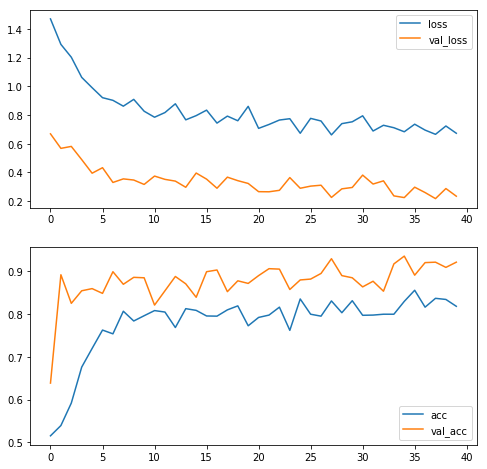

In [5]:
from mateosio import plot_training_histories
%matplotlib inline

plot_training_histories(history);

0.635761589404 0.842105263158


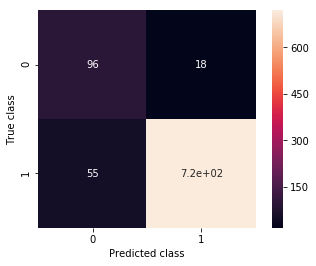

In [6]:
from mateosio import plot_confusion_matrix

ax, precision, recall = plot_confusion_matrix(detector, validation_generator_noshuffle)
print(precision, recall)

OK! so we have prevented overfitting! Let's push a bit more.

In [7]:
from keras.optimizers import Adam

detector.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-4),
                     metrics=['acc'])

history_pt2 = detector.fit_generator(train_generator,
                                     class_weight = {0: 7, 1: 1},
                                     steps_per_epoch=20,
                                     epochs=30,
                                     validation_data=validation_generator,
                                     validation_steps=10)

detector.save('06-frozen-10e-4.h5')

Epoch 1/30
20/20 [==============================] - 17s 836ms/step - loss: 0.5914 - acc: 0.8685 - val_loss: 0.2246 - val_acc: 0.9160
Epoch 2/30
20/20 [==============================] - 13s 634ms/step - loss: 0.7181 - acc: 0.8443 - val_loss: 0.2322 - val_acc: 0.9119
Epoch 3/30
20/20 [==============================] - 13s 651ms/step - loss: 0.6266 - acc: 0.8561 - val_loss: 0.2327 - val_acc: 0.9130
Epoch 4/30
20/20 [==============================] - 13s 639ms/step - loss: 0.6681 - acc: 0.8415 - val_loss: 0.2522 - val_acc: 0.9049
Epoch 5/30
20/20 [==============================] - 13s 634ms/step - loss: 0.6652 - acc: 0.8393 - val_loss: 0.2464 - val_acc: 0.9079
Epoch 6/30
20/20 [==============================] - 13s 626ms/step - loss: 0.6495 - acc: 0.8505 - val_loss: 0.2427 - val_acc: 0.9119
Epoch 7/30
20/20 [==============================] - 13s 637ms/step - loss: 0.6570 - acc: 0.8375 - val_loss: 0.2567 - val_acc: 0.9008
Epoch 8/30
20/20 [==============================] - 14s 724ms/step - 

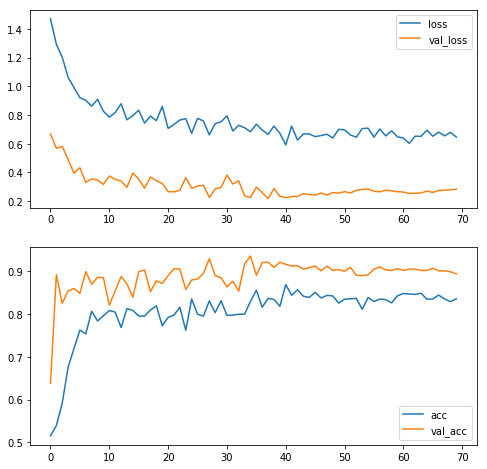

In [8]:
plot_training_histories(history, history_pt2);

0.563535911602 0.894736842105


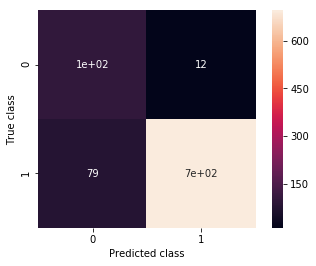

In [9]:
ax, precision, recall = plot_confusion_matrix(detector, validation_generator_noshuffle)
print(precision, recall)

Wow, now we have some recalcitrant underfitting! Time to complexify the model, I guess! We'll unfreeze the convolutional base, like we did in the previous notebook. Let's hope we have hit the sweet spot of the bias-variance trade-off.

### Fine Tuning

In [10]:
# The VGG16 inside my model:

detector.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
__________

In [11]:
for layer in detector.layers[0].layers:
    if 'block5' in layer.name: 
        layer.trainable = True
    else: 
        layer.trainable = False
        
# Set the vgg as a whole to trainable:        
detector.layers[0].trainable = True   

In [12]:
[layer.trainable for layer in detector.layers[0].layers]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True]

In [13]:
detector.layers[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120, 120, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0         
__________

In [14]:
detector.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-4),
                     metrics=['acc'])

history_pt3 = detector.fit_generator(train_generator,
                                     class_weight = {0: 7, 1: 1},
                                     steps_per_epoch=20,
                                     epochs=25,
                                     validation_data=validation_generator,
                                     validation_steps=10)

detector.save('06-unfrozen-10e-4.h5')

Epoch 1/25
20/20 [==============================] - 16s 786ms/step - loss: 0.7793 - acc: 0.8115 - val_loss: 0.2613 - val_acc: 0.8897
Epoch 2/25
20/20 [==============================] - 12s 597ms/step - loss: 0.6325 - acc: 0.8266 - val_loss: 0.2061 - val_acc: 0.9302
Epoch 3/25
20/20 [==============================] - 13s 644ms/step - loss: 0.5932 - acc: 0.8611 - val_loss: 0.3128 - val_acc: 0.8664
Epoch 4/25
20/20 [==============================] - 12s 608ms/step - loss: 0.5703 - acc: 0.8815 - val_loss: 0.2859 - val_acc: 0.8623
Epoch 5/25
20/20 [==============================] - 12s 615ms/step - loss: 0.5912 - acc: 0.8190 - val_loss: 0.1847 - val_acc: 0.9494
Epoch 6/25
20/20 [==============================] - 12s 610ms/step - loss: 0.4858 - acc: 0.9045 - val_loss: 0.2679 - val_acc: 0.8816
Epoch 7/25
20/20 [==============================] - 12s 599ms/step - loss: 0.4840 - acc: 0.8824 - val_loss: 0.1873 - val_acc: 0.9291
Epoch 8/25
20/20 [==============================] - 14s 692ms/step - 

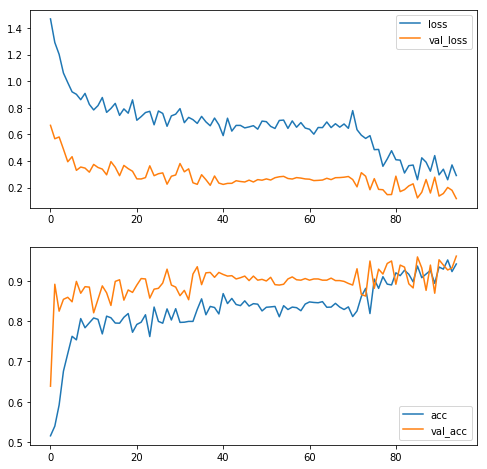

In [15]:
plot_training_histories(history, history_pt2, history_pt3);

0.847457627119 0.877192982456


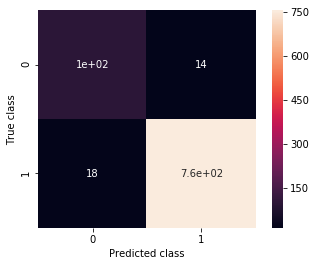

In [16]:
ax, precision, recall = plot_confusion_matrix(detector, validation_generator_noshuffle)
print(precision, recall)

In [17]:
detector.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-5),
                     metrics=['acc'])

history_pt4 = detector.fit_generator(train_generator,
                                     class_weight = {0: 7, 1: 1},
                                     steps_per_epoch=20,
                                     epochs=25,
                                     validation_data=validation_generator,
                                     validation_steps=10)

detector.save('06-unfrozen-10e-5.h5')

Epoch 1/25
20/20 [==============================] - 15s 771ms/step - loss: 0.2492 - acc: 0.9564 - val_loss: 0.1385 - val_acc: 0.9464
Epoch 2/25
20/20 [==============================] - 12s 615ms/step - loss: 0.2152 - acc: 0.9490 - val_loss: 0.1489 - val_acc: 0.9464
Epoch 3/25
20/20 [==============================] - 13s 653ms/step - loss: 0.2795 - acc: 0.9400 - val_loss: 0.1369 - val_acc: 0.9504
Epoch 4/25
20/20 [==============================] - 12s 599ms/step - loss: 0.1978 - acc: 0.9547 - val_loss: 0.1537 - val_acc: 0.9342
Epoch 5/25
20/20 [==============================] - 12s 607ms/step - loss: 0.2507 - acc: 0.9415 - val_loss: 0.1345 - val_acc: 0.9464
Epoch 6/25
20/20 [==============================] - 12s 606ms/step - loss: 0.2014 - acc: 0.9560 - val_loss: 0.1377 - val_acc: 0.9464
Epoch 7/25
20/20 [==============================] - 12s 603ms/step - loss: 0.2496 - acc: 0.9464 - val_loss: 0.1660 - val_acc: 0.9453
Epoch 8/25
20/20 [==============================] - 14s 705ms/step - 

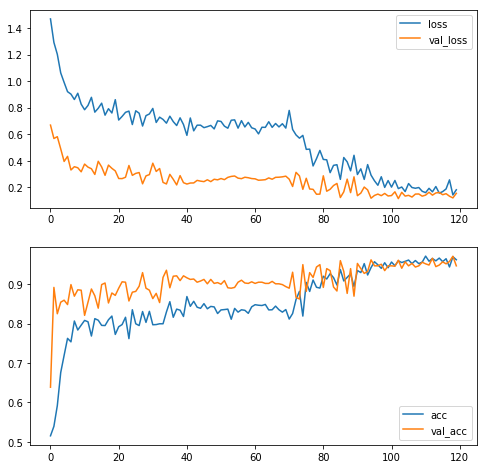

In [18]:
plot_training_histories(history, history_pt2, history_pt3, history_pt4);

0.723684210526 0.964912280702


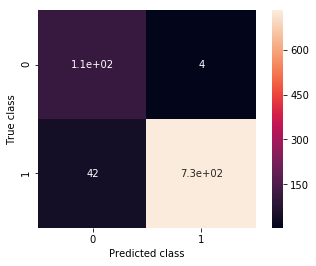

In [19]:
from mateosio import plot_confusion_matrix

ax, precision, recall = plot_confusion_matrix(detector, validation_generator_noshuffle)
print(precision, recall)

In [20]:
from keras.models import load_model

detector = load_model('06-unfrozen-10e-5.h5')